<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/Feature_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
VGG16 Feature Maps:


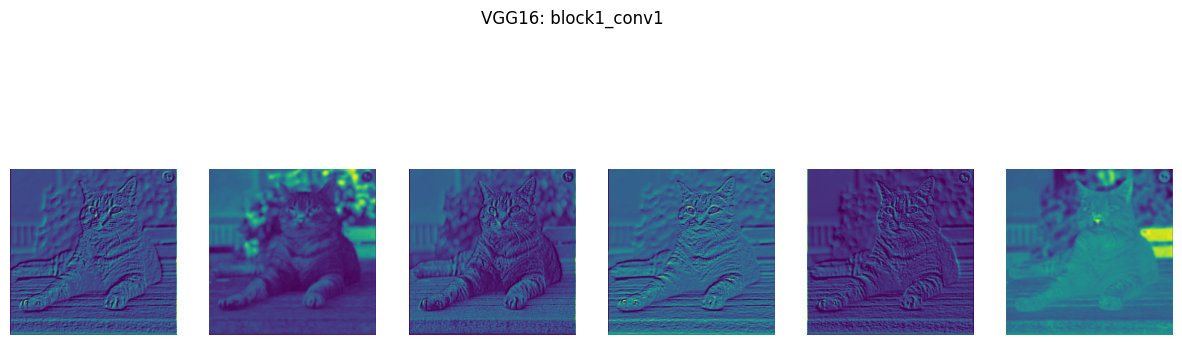

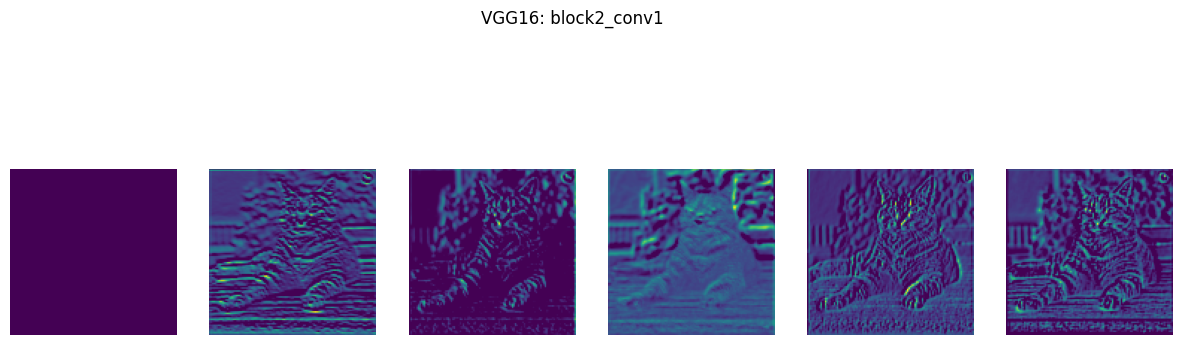

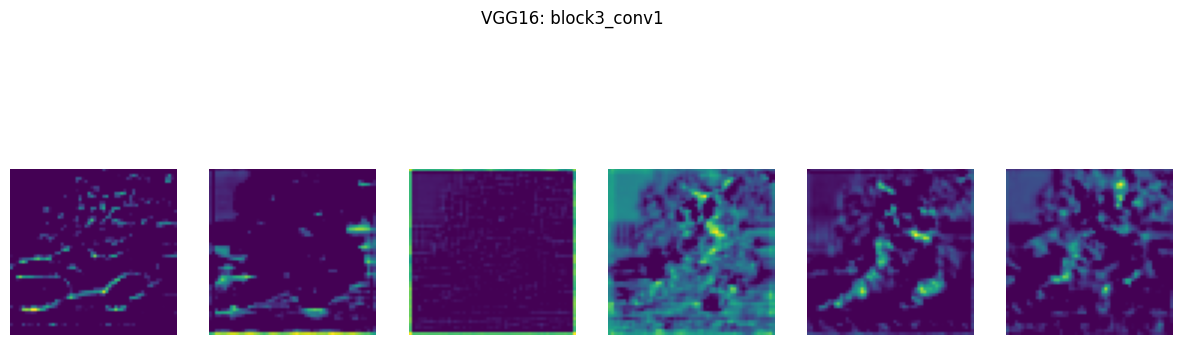

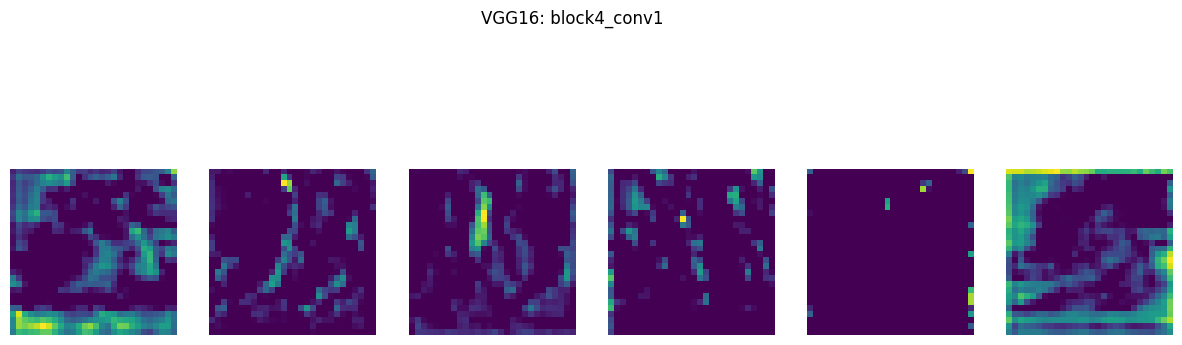

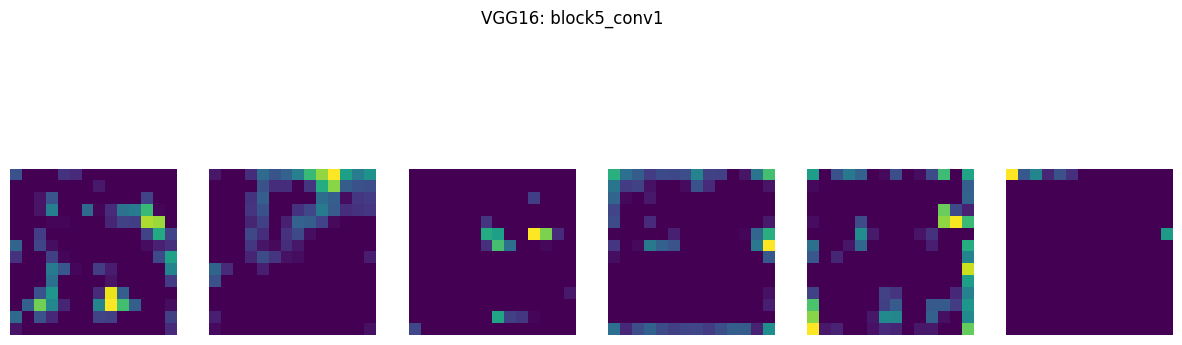

Custom CNN Feature Maps:


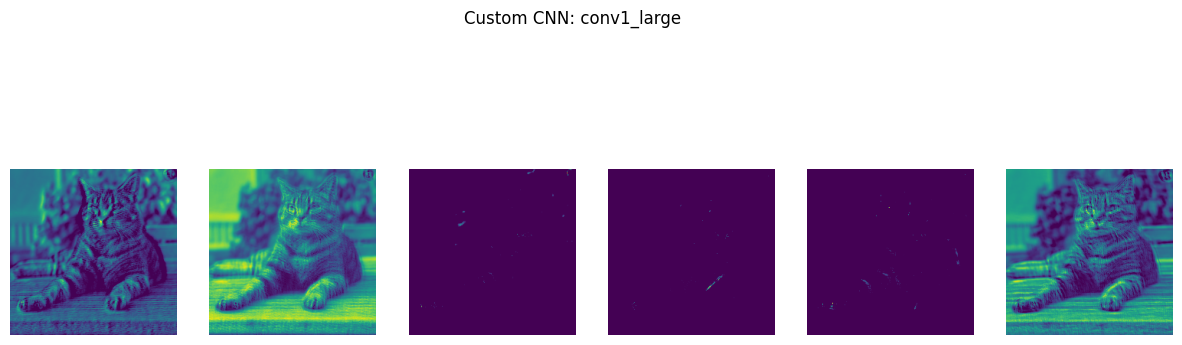

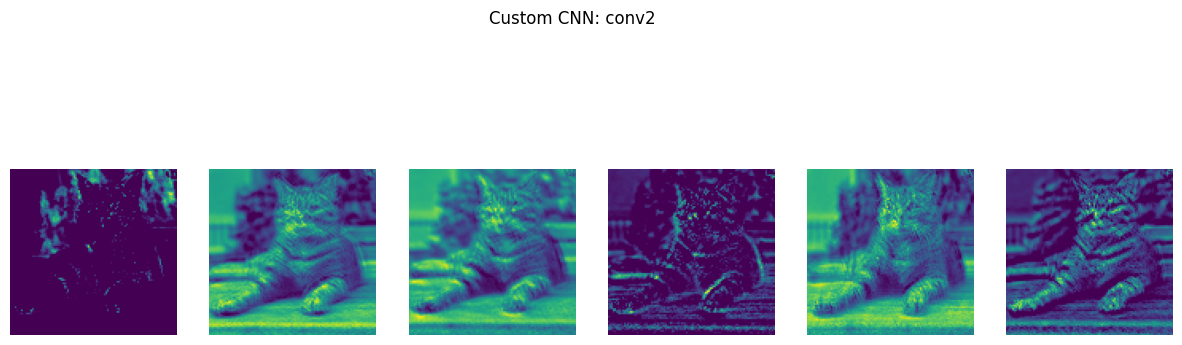

In [7]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# ========================== Image Preprocessing ==========================
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize for VGG16 and custom model
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize
    return img

# Load an image (Replace 'your_image.jpg' with the actual image path)
img_path = '/content/cat.jpg'
image = preprocess_image(img_path)

# ========================== VGG16 Feature Extraction ==========================
vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

# Define layers to extract
vgg_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
vgg_outputs = [vgg_model.get_layer(name).output for name in vgg_layers]

# Create VGG16 feature extractor model
vgg_feature_model = Model(inputs=vgg_model.input, outputs=vgg_outputs)
vgg_feature_maps = vgg_feature_model.predict(image)

# ====================== Custom CNN with Large Filters ========================
inputs = Input(shape=(224, 224, 3))

x = Conv2D(16, (7,7), activation='relu', name="conv1_large")(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (5,5), activation='relu', name="conv2")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', name="conv3")(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)  # Dummy classification layer

custom_model = Model(inputs=inputs, outputs=outputs)

# Extract feature maps from first two layers
custom_layers = ["conv1_large", "conv2"]
custom_outputs = [custom_model.get_layer(name).output for name in custom_layers]
custom_feature_model = Model(inputs=custom_model.input, outputs=custom_outputs)
custom_feature_maps = custom_feature_model.predict(image)

# =========================== Visualization Function ==========================
def plot_feature_maps(feature_maps, layer_names, title):
    for fmap, layer_name in zip(feature_maps, layer_names):
        num_filters = fmap.shape[-1]
        fig, axes = plt.subplots(1, min(6, num_filters), figsize=(15, 5))
        fig.suptitle(f"{title}: {layer_name}")

        for i in range(min(6, num_filters)):  # Show first 6 feature maps
            axes[i].imshow(fmap[0, :, :, i], cmap="viridis")
            axes[i].axis("off")

        plt.show()

# ========================== Display Feature Maps ==========================
print("VGG16 Feature Maps:")
plot_feature_maps(vgg_feature_maps, vgg_layers, "VGG16")

print("Custom CNN Feature Maps:")
plot_feature_maps(custom_feature_maps, custom_layers, "Custom CNN")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


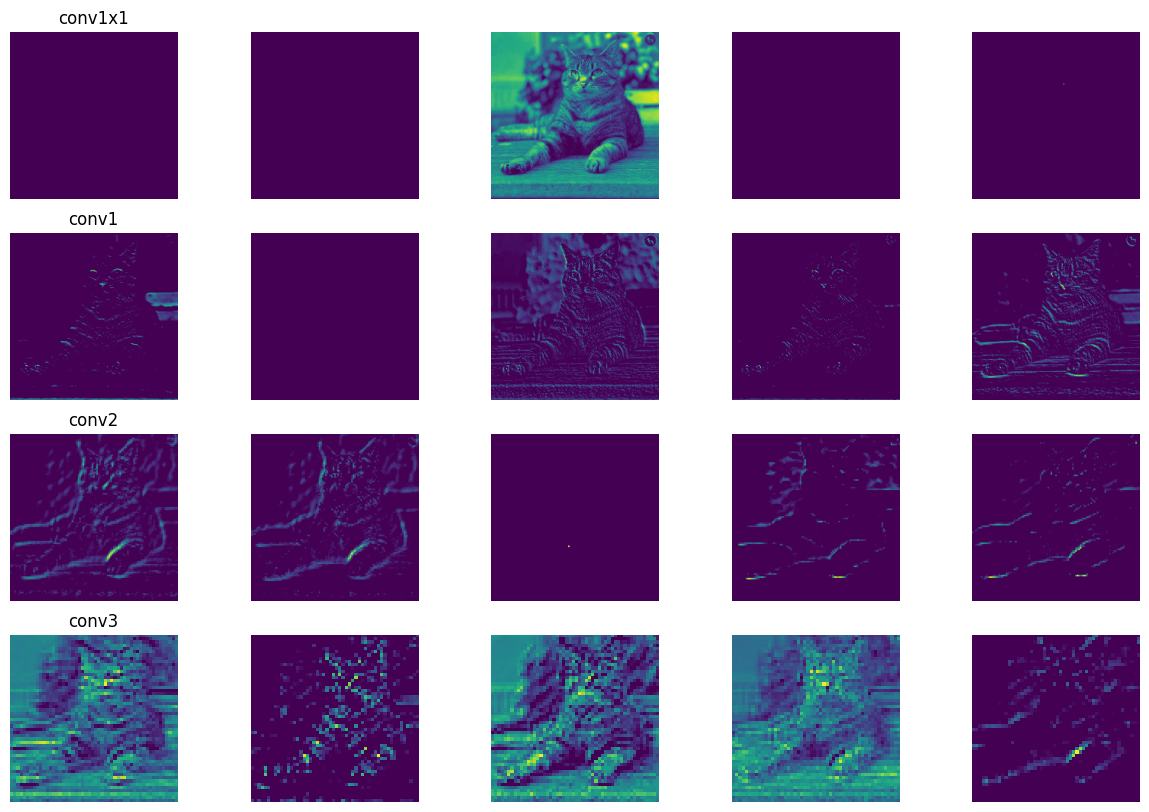

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ====================== Step 1: Define the CNN Model ====================== #
def build_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))  # Explicit Input Layer

    # 1×1 Convolution Layer to capture only local patterns
    x = tf.keras.layers.Conv2D(8, (1,1), activation='relu', name='conv1x1')(inputs)

    # First Convolution Layer with reduced filters (16 instead of 32)
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', name='conv1')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    # Additional Convolution Layers
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', name='conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='conv3')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', name='fc1')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='output')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="CustomCNN")
    return model

# Build and compile the model
model = build_model()

# Call the model once with a dummy input to define its computation graph
dummy_input = np.random.rand(1, 224, 224, 3).astype(np.float32)
_ = model(dummy_input)  # Calling the model once to initialize

# ====================== Step 2: Load and Preprocess Image ====================== #
def preprocess_image(image_path):
    """Loads and preprocesses an image for the CNN."""
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = img.astype(np.float32) / 255.0  # Normalize
    return np.expand_dims(img, axis=0)  # Expand dimensions for batch format

# Load and preprocess the image
image_path = "/content/cat.jpg"  # Change this to your image path
test_image = preprocess_image(image_path)

# ====================== Step 3: Visualize Feature Maps ====================== #
def visualize_feature_maps(model, image, layer_names):
    """Extracts and visualizes feature maps from specified layers."""

    # Ensure the layers exist in the model
    valid_layers = [name for name in layer_names if name in [layer.name for layer in model.layers]]

    # Create a model that outputs the feature maps from the selected layers
    feature_model = tf.keras.Model(
        inputs=model.input,
        outputs=[model.get_layer(name).output for name in valid_layers]
    )

    # Run model prediction to get feature maps
    feature_maps = feature_model.predict(image)

    fig, axes = plt.subplots(len(valid_layers), 5, figsize=(15, 10))
    for i, feature_map in enumerate(feature_maps):
        for j in range(5):  # Show first 5 feature maps
            if j < feature_map.shape[-1]:  # Ensure the feature map exists
                axes[i, j].imshow(feature_map[0, :, :, j], cmap='viridis')
                axes[i, j].axis('off')
        axes[i, 0].set_title(valid_layers[i])

    plt.show()

# Choose layers to visualize
layer_names = ['conv1x1', 'conv1', 'conv2', 'conv3']
visualize_feature_maps(model, test_image, layer_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


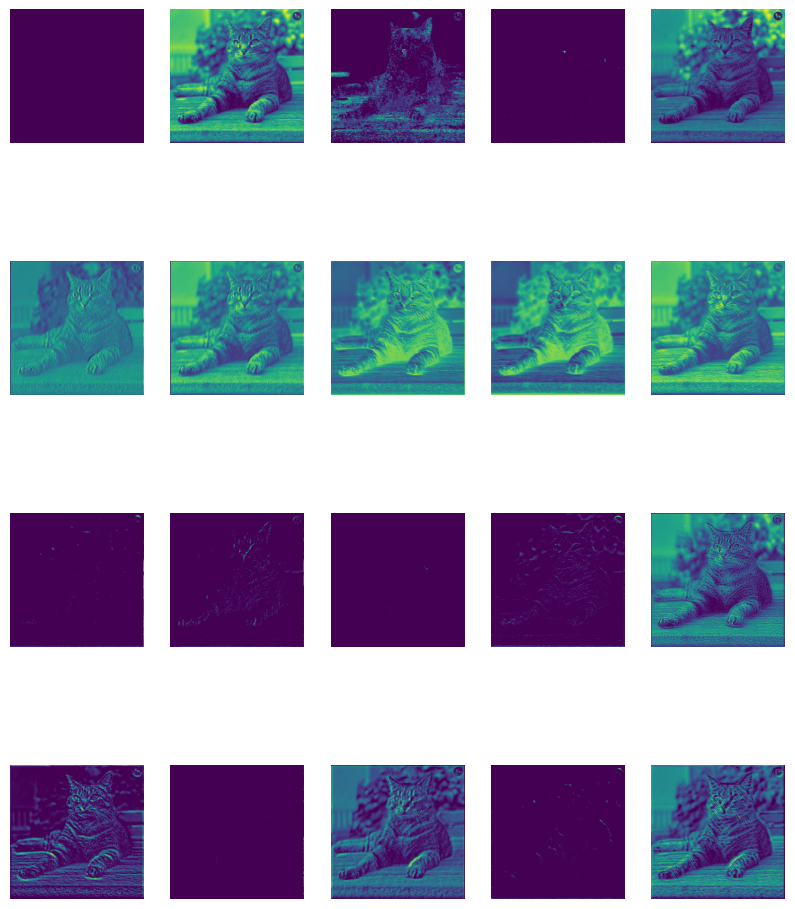

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Input
from tensorflow.keras.preprocessing import image

# ================== Define the CNN Model ==================
def build_model():
    inputs = Input(shape=(224, 224, 3))  # Explicitly define input shape

    x = Conv2D(8, (1, 1), activation='relu', padding='same', name='conv1x1')(inputs)  # 1x1 conv
    x = Conv2D(16, (3, 3), padding='same', name='conv1')(x)  # First conv layer
    x = BatchNormalization()(x)  # Normalization
    x = ReLU()(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)

    model = Model(inputs, x, name="Custom_CNN")
    return model

# ================== Load and Preprocess Image ==================
def preprocess_image(img_path, grayscale=False):
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale' if grayscale else 'rgb')
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# ================== Feature Map Visualization ==================
def visualize_feature_maps(model, img_array, layer_names):
    feature_model = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names])
    feature_maps = feature_model.predict(img_array)

    fig, axes = plt.subplots(len(layer_names), 5, figsize=(10, len(layer_names) * 3))
    fig.subplots_adjust(hspace=0.5)

    for i, fmap in enumerate(feature_maps):
        for j in range(min(5, fmap.shape[-1])):  # Show up to 5 feature maps per layer
            ax = axes[i, j]
            ax.imshow(fmap[0, :, :, j], cmap='viridis')
            ax.axis('off')
        axes[i, 0].set_ylabel(layer_names[i], fontsize=12)  # Label each row

    plt.show()

# ================== Run the Code ==================
model = build_model()
test_image = preprocess_image("/content/cat.jpg")  # Provide your image path
layer_names = ['conv1x1', 'conv1', 'conv2', 'conv3']

visualize_feature_maps(model, test_image, layer_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


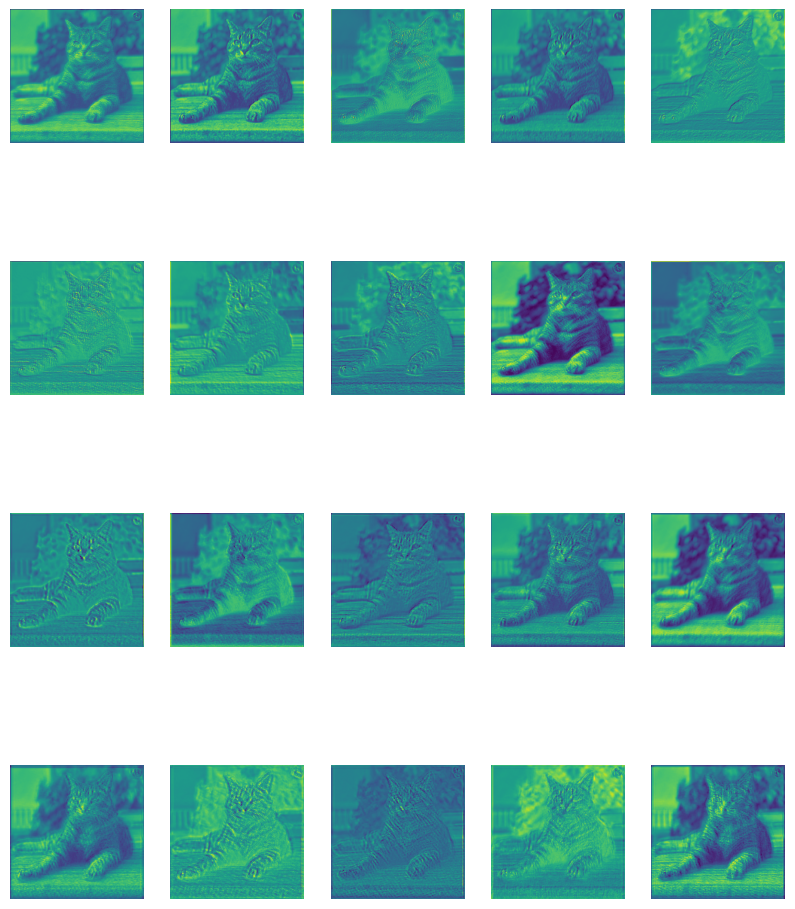

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Input
from tensorflow.keras.preprocessing import image

# ================== Define the Optimized Model ==================
def build_model():
    inputs = Input(shape=(224, 224, 3))  # Explicit input shape

    # Step 1: Start with small filters (3×3) to extract local details
    x = Conv2D(16, (3, 3), padding='same', name='conv1')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Step 2: Increase to 5×5 for mid-level patterns
    x = Conv2D(64, (5, 5), padding='same', name='conv3')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Step 3: Use a 7×7 filter later for large-scale pattern learning
    x = Conv2D(128, (7, 7), padding='same', name='conv4')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    model = Model(inputs, x, name="Custom_CNN")
    return model

# ================== Load and Preprocess Image ==================
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# ================== Feature Map Visualization ==================
def visualize_feature_maps(model, img_array, layer_names):
    feature_model = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names])
    feature_maps = feature_model.predict(img_array)

    fig, axes = plt.subplots(len(layer_names), 5, figsize=(10, len(layer_names) * 3))
    fig.subplots_adjust(hspace=0.5)

    for i, fmap in enumerate(feature_maps):
        for j in range(min(5, fmap.shape[-1])):  # Show up to 5 feature maps per layer
            ax = axes[i, j]
            ax.imshow(fmap[0, :, :, j], cmap='viridis')
            ax.axis('off')
        axes[i, 0].set_ylabel(layer_names[i], fontsize=12)  # Label each row

    plt.show()

# ================== Run the Code ==================
model = build_model()
test_image = preprocess_image("/content/cat.jpg")  # Provide your image path
layer_names = ['conv1', 'conv2', 'conv3', 'conv4']

visualize_feature_maps(model, test_image, layer_names)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.4517 - loss: 1.4818 - val_accuracy: 0.4649 - val_loss: 1.4948
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.4514 - loss: 1.3907 - val_accuracy: 0.4649 - val_loss: 1.4853
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5326 - loss: 1.2153 - val_accuracy: 0.6184 - val_loss: 1.4180
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.6639 - loss: 0.8864 - val_accuracy: 0.5263 - val_loss: 1.4380
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.7847 - loss: 0.6312 - val_accuracy: 0.1360 - val_loss: 1.5912
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8467 - loss: 0.4575 - val_accuracy: 0.2895 - val_loss: 1.4756
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8579 - loss: 0.4080 - val_accuracy: 0.3991 - val_loss: 1.3356
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.8831 - loss: 0.3623 - val_accuracy: 0.5

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_261']
Received: inputs=Tensor(shape=(1, 50, 37, 3))
  warnings.warn(msg)


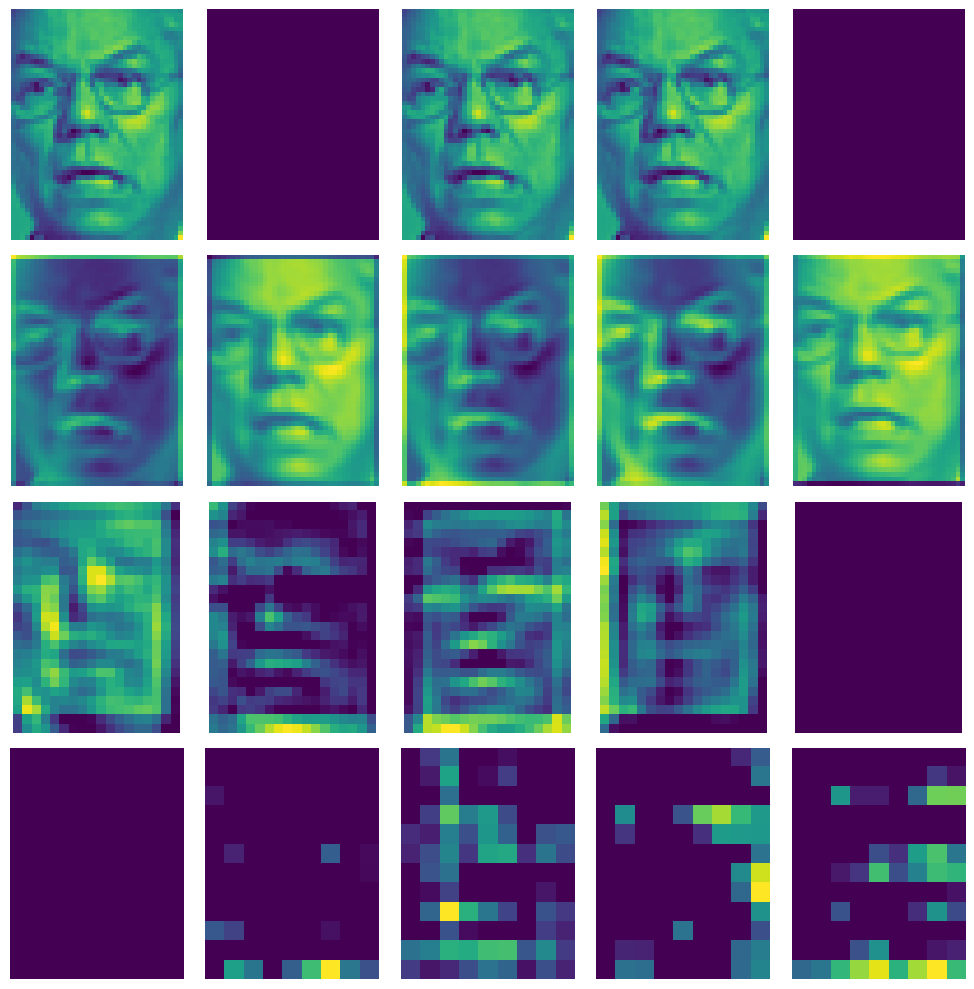

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, ReLU

# ================== 1. Load LFW Face Dataset ==================
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)  # Get faces with at least 100 samples
X = lfw_people.images  # Grayscale face images
y = lfw_people.target  # Labels (person IDs)

# Convert grayscale to RGB (since CNNs usually work with 3 channels)
X = np.stack((X,) * 3, axis=-1) / 255.0  # Normalize to [0,1]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ================== 2. Define CNN Model ==================
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 1x1 Convolution to extract local patterns
    x = Conv2D(8, (1,1), activation='relu', padding='same', name='conv1x1')(inputs)

    # First Convolutional Layer (smaller filters first)
    x = Conv2D(16, (3,3), padding='same', name='conv1')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x)

    # Second Convolutional Layer
    x = Conv2D(32, (5,5), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2,2))(x)

    # Third Convolutional Layer
    x = Conv2D(64, (7,7), activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D((2,2))(x)

    # Fully Connected Layer
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Build and compile the model
model = build_model(X_train.shape[1:], num_classes=len(np.unique(y)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ================== 3. Train the Model ==================
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# ================== 4. Feature Map Visualization Function ==================
def visualize_feature_maps(model, image, layer_names):
    """ Extract and visualize feature maps from selected layers """
    feature_extractor = Model(inputs=model.inputs, outputs=[model.get_layer(name).output for name in layer_names])
    feature_maps = feature_extractor.predict(np.expand_dims(image, axis=0))  # Add batch dimension

    fig, axes = plt.subplots(len(layer_names), 5, figsize=(10, 10))

    for layer_idx, feature_map in enumerate(feature_maps):
        axes[layer_idx, 0].set_ylabel(layer_names[layer_idx], fontsize=12)

        # Show the first 5 feature maps from each layer
        for i in range(5):
            if i < feature_map.shape[-1]:  # Check if there are enough feature maps
                axes[layer_idx, i].imshow(feature_map[0, :, :, i], cmap='viridis')
            axes[layer_idx, i].axis('off')

    plt.tight_layout()
    plt.show()

# ================== 5. Select a Test Image and Visualize Feature Maps ==================
test_image = X_test[0]  # Pick a random face from test set
layer_names = ['conv1x1', 'conv1', 'conv2', 'conv3']
visualize_feature_maps(model, test_image, layer_names)
